In [1]:
from nbconvert.preprocessors import ExecutePreprocessor
import nbformat

# ✅ Flag de control
ejecutar_ingestion = False  # ← cambialo a True si querés ejecutar la ingesta

if ejecutar_ingestion:
    ruta_ingesta = "D:/trading/notebooks/sandbox/test_ingestion_Twelve_Data_API.ipynb"
    with open(ruta_ingesta, encoding="utf-8") as f:
        nb = nbformat.read(f, as_version=4)

    print("🚀 Ejecutando notebook de ingesta de datos...")
    ep = ExecutePreprocessor(timeout=600, kernel_name="python3")
    ep.preprocess(nb, {"metadata": {"path": "D:/trading/notebooks/sandbox"}})
    print("✅ Ingesta finalizada.")
else:
    print("⏭️ Ingesta omitida. Continuando con el proceso...")


⏭️ Ingesta omitida. Continuando con el proceso...


In [2]:
# ✅ Paso 2: Importar dependencias
import os
import pandas as pd
from datetime import datetime
from pathlib import Path
from importlib import import_module
import sys

In [3]:
# ✅ Paso 3: Configuracion de rutas
BASE_DIR = Path("D:/trading")
HISTORIC_DIR = BASE_DIR / "data/historic_reciente"
ESTRATEGIAS_PATH = BASE_DIR / "my_modules/estrategias"
OUTPUT_PATH = BASE_DIR / "reports/senales_heuristicas/diarias"
CONFIG_PATH = BASE_DIR / "config/symbol_groups.json"

In [4]:
# ✅ Paso 4: Cargar estrategias tuneadas
desarrollos = {}
sys.path.append(str(BASE_DIR))  # para que my_modules sea importable

for archivo in os.listdir(ESTRATEGIAS_PATH):
    if archivo.endswith(".py"):
        nombre_modulo = archivo[:-3]
        try:
            mod = import_module(f"my_modules.estrategias.{nombre_modulo}")
            desarrollos[nombre_modulo] = mod.generar_senales
            print(f"✅ Estrategia cargada: {nombre_modulo}")
        except Exception as e:
            print(f"❌ No se pudo cargar {nombre_modulo}: {e}")

✅ Estrategia cargada: adx_filter_trend_v4
✅ Estrategia cargada: bollinger_breakout_v4
✅ Estrategia cargada: breakout_volumen_v4
✅ Estrategia cargada: cruce_medias_v4
✅ Estrategia cargada: ema_9_21_cruce_v4
✅ Estrategia cargada: ema_pullback_v4
✅ Estrategia cargada: gap_open_strategy_v4


In [5]:
# ✅ Paso 5: Cargar símbolos
grupos = pd.read_json(CONFIG_PATH)
simbolos = sorted(set(sum(grupos.values.tolist(), [])))

In [6]:
from datetime import date

# ✅ Paso 6: Procesar cada símbolo
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

for simbolo in simbolos:
    archivo = HISTORIC_DIR / f"{simbolo}.parquet"
    if not archivo.exists():
        print(f"⚠️ Historico no encontrado para {simbolo}. Saltado.")
        continue

    try:
        df = pd.read_parquet(archivo)
        if df.empty or "fecha" not in df.columns:
            print(f"⚠️ Historico invalido para {simbolo}.")
            continue

        df["fecha"] = pd.to_datetime(df["fecha"])
        df = df[df["fecha"] < pd.Timestamp.today()]  # ← 💡 filtra posibles datos parciales de hoy
        if df.empty:
            print(f"⚠️ No hay datos previos a hoy para {simbolo}.")
            continue

        ultima_fecha = df["fecha"].max()

        resultados = []
        for nombre_est, funcion in desarrollos.items():
            try:
                df_out = funcion(df.copy())
                if df_out is not None and not df_out.empty:
                    df_out["fecha"] = pd.to_datetime(df_out["fecha"])
                    df_out = df_out[df_out["fecha"] == ultima_fecha]
                    if not df_out.empty:
                        df_out["simbolo"] = simbolo
                        df_out["estrategia"] = nombre_est
                        resultados.append(df_out)
            except Exception as e:
                print(f"❌ {nombre_est} falló con {simbolo}: {e}")

        if resultados:
            df_final = pd.concat(resultados)
            df_final = df_final.sort_values("fecha")
            df_final.to_csv(OUTPUT_PATH / f"{simbolo}_senales_diarias.csv", index=False)
            print(f"✅ Señales generadas para {simbolo}.")
        else:
            print(f"⏭️ No hubo señales para {simbolo}.")

    except Exception as e:
        print(f"❌ Error general con {simbolo}: {e}")

D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para AAPL.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para AMD.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para AMZN.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para AVGO.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para BABA.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para BAC.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para CRM.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para CTVA.
⚠️ Historico no encontrado para DEL. Saltado.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para DGX.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para ED.
⚠️ Historico no encontrado para EQCF. Saltado.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para EQR.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para EXE.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para F.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para FITBO.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para FWONA.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para GOOGL.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para HBANL.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para HBANM.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para HBANP.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para HIMS.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para HOOD.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para INTC.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para JPM.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para KHC.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para LLY.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para MCHPP.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para META.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para MRK.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para MSFT.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para NIO.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para NKE.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para NVDA.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para ORCL.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para PFE.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para PLTR.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para RPRX.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para SKX.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para SMCI.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para SOJC.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para TBB.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para TMO.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para TSLA.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para TSM.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para UBER.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para V.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para WFC.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para WMT.


D:\trading\my_modules\estrategias\ema_pullback_v4.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = pd.Series(df["buy_cond"].shift(1)).fillna(False).astype(bool)


✅ Señales generadas para XOM.


In [7]:

# === Ruta de señales heurísticas ===
OUTPUT_PATH = Path("D:/trading/reports/senales_heuristicas/diarias")

# === Cargar todas las señales en un único DataFrame ===
df_lista = []
for archivo in OUTPUT_PATH.glob("*.csv"):
    try:
        df = pd.read_csv(archivo)
        if "simbolo" in df.columns and "signal" in df.columns:
            df_lista.append(df)
    except Exception as e:
        print(f"❌ Error al leer {archivo.name}: {e}")

if not df_lista:
    print("⚠️ No se encontraron señales.")
else:
    df_all = pd.concat(df_lista).dropna(subset=["signal"])
    df_all["signal"] = df_all["signal"].str.lower().str.strip()

    # Clasificación por símbolo
    resumen = df_all.groupby("simbolo")["signal"].apply(lambda s: set(s)).reset_index()
    resumen["buy"] = resumen["signal"].apply(lambda x: "buy" in x)
    resumen["sell"] = resumen["signal"].apply(lambda x: "sell" in x)
    resumen["hold_only"] = resumen["signal"].apply(lambda x: x == {"hold"})

    # Reporte
    print("📈 Símbolos con señal BUY:")
    display(resumen[resumen["buy"]]["simbolo"].tolist())

    print("\n📉 Símbolos con señal SELL:")
    display(resumen[resumen["sell"]]["simbolo"].tolist())

#    print("\n🤝 Símbolos con solo HOLD:")
#    display(resumen[resumen["hold_only"]]["simbolo"].tolist())


📈 Símbolos con señal BUY:


['AMD',
 'AMZN',
 'AVGO',
 'BAC',
 'CTVA',
 'DGX',
 'EQR',
 'EXE',
 'FWONA',
 'GOOGL',
 'HIMS',
 'HOOD',
 'JPM',
 'LLY',
 'MCHPP',
 'META',
 'MSFT',
 'NKE',
 'NVDA',
 'ORCL',
 'PFE',
 'PLTR',
 'RPRX',
 'SKX',
 'SMCI',
 'TSLA',
 'TSM',
 'UBER',
 'V',
 'WFC',
 'WMT']


📉 Símbolos con señal SELL:


['AAPL',
 'BABA',
 'CRM',
 'DGX',
 'ED',
 'EQR',
 'F',
 'FITBO',
 'HBANL',
 'HBANM',
 'HBANP',
 'INTC',
 'KHC',
 'LLY',
 'MRK',
 'NIO',
 'RPRX',
 'SOJC',
 'TBB',
 'TMO',
 'UBER',
 'XOM']

In [8]:
OUTPUT_PATH = Path("D:/trading/reports/senales_heuristicas/diarias")
df_lista = []

# Cargar todas las señales
for archivo in OUTPUT_PATH.glob("*.csv"):
    try:
        df = pd.read_csv(archivo)
        if {"simbolo", "signal", "estrategia"}.issubset(df.columns):
            df_lista.append(df)
    except Exception as e:
        print(f"❌ Error en {archivo.name}: {e}")

if df_lista:
    df_all = pd.concat(df_lista).dropna(subset=["signal"])
    df_all["signal"] = df_all["signal"].str.lower().str.strip()

    # Filtrar solo BUY y SELL
    df_all = df_all[df_all["signal"].isin(["buy", "sell"])]

    # Agrupar estrategias por tipo de señal
    df_pivot = df_all.groupby(["simbolo", "signal"])["estrategia"] \
        .apply(lambda x: ", ".join(sorted(set(x)))).unstack(fill_value="")

    df_pivot.reset_index(inplace=True)
    df_pivot.columns.name = None
    df_pivot.rename(columns={"buy": "Estrategias BUY", "sell": "Estrategias SELL"}, inplace=True)

    display(df_pivot)
else:
    print("⚠️ No se encontraron señales válidas.")

,simbolo,Estrategias BUY,Estrategias SELL
0,AAPL,,"adx_filter_trend_v4, ema_9_21_cruce_v4"
1,AMD,"adx_filter_trend_v4, ema_9_21_cruce_v4",
2,AMZN,"adx_filter_trend_v4, ema_9_21_cruce_v4",
3,AVGO,"adx_filter_trend_v4, breakout_volumen_v4, ema_...",
4,BABA,,"adx_filter_trend_v4, ema_9_21_cruce_v4"
5,BAC,"adx_filter_trend_v4, ema_9_21_cruce_v4",
6,CRM,,"adx_filter_trend_v4, ema_9_21_cruce_v4"
7,CTVA,"adx_filter_trend_v4, ema_9_21_cruce_v4",
8,DGX,ema_pullback_v4,"adx_filter_trend_v4, ema_9_21_cruce_v4"
9,ED,,"adx_filter_trend_v4, ema_9_21_cruce_v4"


In [9]:
import pandas as pd
from pathlib import Path

# === Configuración ===
VENTANA_DIAS = 10  # Cambiá esto si querés evaluar otra ventana

HISTORIC_RECENT_DIR = Path("D:/trading/data/historic_reciente")
simbolos_con_volumen_alto = []

for archivo in HISTORIC_RECENT_DIR.glob("*.parquet"):
    try:
        df = pd.read_parquet(archivo)
        if "volume" not in df.columns or "fecha" not in df.columns:
            continue

        df = df.sort_values("fecha")
        df["volume"] = pd.to_numeric(df["volume"], errors="coerce")

        if df.shape[0] < VENTANA_DIAS + 1:
            continue  # no hay suficientes datos

        # Calcular promedio de los últimos N días (excluyendo el más reciente)
        volumen_ventana = df["volume"].iloc[-VENTANA_DIAS-1:-1].mean()
        volumen_actual = df["volume"].iloc[-1]

        if volumen_actual > 1.1*volumen_ventana:
            simbolo = archivo.stem.upper().replace(".PARQUET", "")
            simbolos_con_volumen_alto.append(simbolo)

    except Exception as e:
        print(f"❌ Error en {archivo.name}: {e}")

# === Mostrar resultado
print(f"📊 Volumen actual > promedio de últimos {VENTANA_DIAS} días para:")
display(sorted(simbolos_con_volumen_alto))



📊 Volumen actual > promedio de últimos 10 días para:


['BABA', 'F', 'FWONA', 'HBANL', 'HBANM', 'META', 'NIO', 'PLTR', 'SOJC', 'XOM']

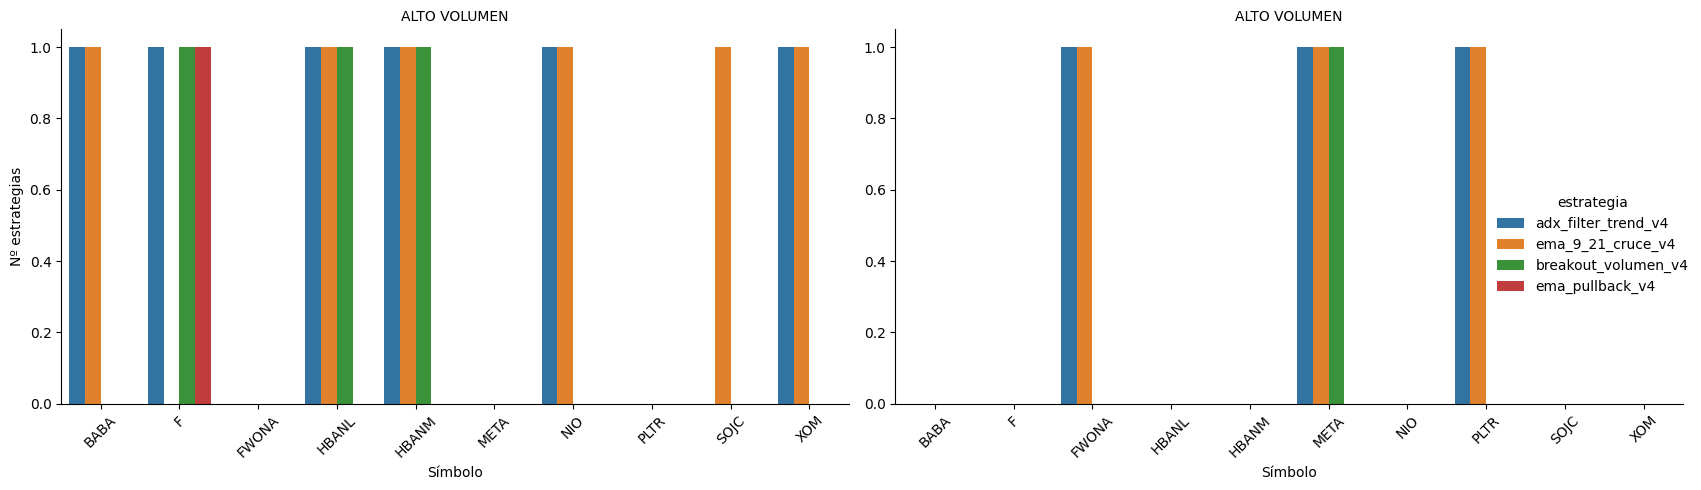

In [10]:
import seaborn as sns
from matplotlib import pyplot as plt

df_filtrado = df_all[df_all["simbolo"].isin(simbolos_con_volumen_alto)]

df_plot = df_filtrado.groupby(["simbolo", "signal", "estrategia"]).size().reset_index(name="conteo")

# Gráfico
g = sns.catplot(
    data=df_plot,
    kind="bar",
    x="simbolo",
    y="conteo",
    hue="estrategia",
    col="signal",
    height=5,
    aspect=1.5,
    sharey=False
)

g.set_titles("ALTO VOLUMEN".upper())
g.set_axis_labels("Símbolo", "Nº estrategias")
g.set_xticklabels(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
# Tabla cruzada
tabla = df_filtrado.pivot_table(index="simbolo", columns="signal", values="estrategia", aggfunc=lambda x: ", ".join(set(x)))

# Agregar volumen actual
volumen_dict = {}
for archivo in HISTORIC_RECENT_DIR.glob("*.parquet"):
    simbolo = archivo.stem.upper()
    if simbolo in simbolos_con_volumen_alto:
        df = pd.read_parquet(archivo)
        if "volume" in df.columns:
            volumen_dict[simbolo] = pd.to_numeric(df["volume"], errors="coerce").iloc[-1]

tabla["volumen_actual"] = tabla.index.map(volumen_dict)
tabla = tabla.fillna("")
display(tabla)


signal,buy,sell,volumen_actual
simbolo,,,
BABA,,"ema_9_21_cruce_v4, adx_filter_trend_v4",13115969
F,,"breakout_volumen_v4, ema_pullback_v4, adx_filt...",170197000
FWONA,"ema_9_21_cruce_v4, adx_filter_trend_v4",,98855
HBANL,,"breakout_volumen_v4, ema_9_21_cruce_v4, adx_fi...",37845
HBANM,,"breakout_volumen_v4, ema_9_21_cruce_v4, adx_fi...",13926
META,"breakout_volumen_v4, ema_9_21_cruce_v4, adx_fi...",,15688676
NIO,,"ema_9_21_cruce_v4, adx_filter_trend_v4",38998065
PLTR,"ema_9_21_cruce_v4, adx_filter_trend_v4",,92123690
SOJC,,ema_9_21_cruce_v4,43315


In [12]:
!pip install plotly


In [16]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [18]:
import plotly.io as pio
print(pio.renderers.default)


notebook_connected


In [19]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"
fig.show()


In [21]:
import pandas as pd
import plotly.graph_objects as go
from pathlib import Path

# === Cargar histórico ===
ruta = Path("D:/trading/data/historic_reciente/SMCI.parquet")
df = pd.read_parquet(ruta)
df["fecha"] = pd.to_datetime(df["fecha"])
df = df.sort_values("fecha")

# Agrupar en bloques de 3 días
df["grupo"] = (df.index // 1)

df_resample = df.groupby("grupo").agg({
    "fecha": "first",
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last",
    "volume": "sum"
}).reset_index(drop=True)

# === Graficar ===
fig = go.Figure(data=[
    go.Candlestick(
        x=df_resample["fecha"],
        open=df_resample["open"],
        high=df_resample["high"],
        low=df_resample["low"],
        close=df_resample["close"],
        name="SMCI (3D velas)"
    )
])

fig.update_layout(
    title="📉 SMCI - Velas agrupadas cada 3 días",
    xaxis_title="Fecha",
    yaxis_title="Precio",
    xaxis_rangeslider_visible=False,
    template="plotly_dark"
)

fig.show()


In [14]:
import pandas as pd
import plotly.graph_objects as go
from pathlib import Path

# === Cargar histórico ===
ruta_hist = Path("D:/trading/data/historic_reciente/SMCI.parquet")
df = pd.read_parquet(ruta_hist)
df["fecha"] = pd.to_datetime(df["fecha"])
df = df.sort_values("fecha").reset_index(drop=True)

# Agrupar en bloques de 3 días
df["grupo"] = (df.index // 3)
df_candle = df.groupby("grupo").agg({
    "fecha": "first",
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last",
    "volume": "sum"
}).reset_index(drop=True)

# === Cargar señales ===
ruta_senales = Path("D:/trading/reports/senales_heuristicas/diarias/SMCI_senales_diarias.csv")
df_senales = pd.read_csv(ruta_senales)
df_senales["fecha"] = pd.to_datetime(df_senales["fecha"])

# Unir señales con histórico diario para obtener precios
df_merge = pd.merge(df_senales, df[["fecha", "close"]], on="fecha", how="left")

# === Crear gráfico de velas ===
fig = go.Figure()

fig.add_trace(go.Candlestick(
    x=df_candle["fecha"],
    open=df_candle["open"],
    high=df_candle["high"],
    low=df_candle["low"],
    close=df_candle["close"],
    name="SMCI (3D velas)"
))

# === Añadir señales BUY ===
df_buy = df_merge[df_merge["signal"].str.lower() == "buy"]
fig.add_trace(go.Scatter(
    x=df_buy["fecha"],
    y=df_buy["close"],
    mode="markers+text",
    name="BUY",
    text=["BUY"] * len(df_buy),
    textposition="bottom center",
    marker=dict(color="lime", size=10, symbol="triangle-up")
))

# === Añadir señales SELL ===
df_sell = df_merge[df_merge["signal"].str.lower() == "sell"]
fig.add_trace(go.Scatter(
    x=df_sell["fecha"],
    y=df_sell["close"],
    mode="markers+text",
    name="SELL",
    text=["SELL"] * len(df_sell),
    textposition="top center",
    marker=dict(color="red", size=10, symbol="triangle-down")
))

# === Estilo ===
fig.update_layout(
    title="📈 SMCI - Velas 3 días + Señales Heurísticas",
    xaxis_title="Fecha",
    yaxis_title="Precio",
    xaxis_rangeslider_visible=False,
    template="plotly_white",
    height=600
)

fig.show()



KeyError: 'close'

In [15]:
import pandas as pd
import plotly.graph_objects as go
from pathlib import Path

# === Cargar histórico ===
ruta_hist = Path("D:/trading/data/historic_reciente/SMCI.parquet")
df = pd.read_parquet(ruta_hist)
df["fecha"] = pd.to_datetime(df["fecha"])
df = df.sort_values("fecha").reset_index(drop=True)

# Agrupar en bloques de 3 días
df["grupo"] = df.index // 3
df_candle = df.groupby("grupo").agg({
    "fecha": "first",
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last",
    "volume": "sum"
}).reset_index(drop=True)

# === Cargar señales ===
ruta_senales = Path("D:/trading/reports/senales_heuristicas/diarias/SMCI_senales_diarias.csv")
if ruta_senales.exists():
    df_senales = pd.read_csv(ruta_senales)
    df_senales["fecha"] = pd.to_datetime(df_senales["fecha"])

    # Unir señales con cierre
    df_merged = pd.merge(df_senales, df[["fecha", "close"]], on="fecha", how="left")

    df_buy = df_merged[df_merged["signal"].str.lower() == "buy"]
    df_sell = df_merged[df_merged["signal"].str.lower() == "sell"]
else:
    df_buy = df_sell = pd.DataFrame()
    print("⚠️ No se encontraron señales heurísticas para SMCI.")

# === Crear gráfico ===
fig = go.Figure()

fig.add_trace(go.Candlestick(
    x=df_candle["fecha"],
    open=df_candle["open"],
    high=df_candle["high"],
    low=df_candle["low"],
    close=df_candle["close"],
    name="Velas 3D"
))

if not df_buy.empty:
    fig.add_trace(go.Scatter(
        x=df_buy["fecha"],
        y=df_buy["close"],
        mode="markers+text",
        name="BUY",
        text=["BUY"] * len(df_buy),
        textposition="bottom center",
        marker=dict(color="lime", size=10, symbol="triangle-up")
    ))

if not df_sell.empty:
    fig.add_trace(go.Scatter(
        x=df_sell["fecha"],
        y=df_sell["close"],
        mode="markers+text",
        name="SELL",
        text=["SELL"] * len(df_sell),
        textposition="top center",
        marker=dict(color="red", size=10, symbol="triangle-down")
    ))

fig.update_layout(
    title="📈 SMCI - Velas agrupadas (3 días) con señales heurísticas",
    xaxis_title="Fecha",
    yaxis_title="Precio",
    xaxis_rangeslider_visible=False,
    template="plotly_white",
    height=600
)

fig.show()


KeyError: 'close'